 # Chargement des données

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
import os
import json

# mount my own drive
drive.mount('/content/drive')
# my kaggle key
with open('/content/drive/My Drive/data/kaggle.json','rb') as file :
  kgl_json = json.load(file)
# set environement variable
os.environ['KAGGLE_USERNAME'] = kgl_json["username"]
os.environ['KAGGLE_KEY'] = kgl_json['key']

Mounted at /content/drive


In [3]:
! kaggle competitions download -c favorita-grocery-sales-forecasting

 98% 449M/458M [00:09<00:00, 45.0MB/s]
100% 458M/458M [00:09<00:00, 51.6MB/s]


In [4]:
! sudo mkdir data

In [5]:
! sudo unzip -x /content/favorita-grocery-sales-forecasting.zip

Archive:  /content/favorita-grocery-sales-forecasting.zip
  inflating: holidays_events.csv.7z  
  inflating: items.csv.7z            
  inflating: oil.csv.7z              
  inflating: sample_submission.csv.7z  
  inflating: stores.csv.7z           
  inflating: test.csv.7z             
  inflating: train.csv.7z            
  inflating: transactions.csv.7z     


In [6]:
! sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [7]:
! sudo 7z x  train.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 474092593 bytes (453 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 474092593
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train.csv                  1% - train.csv                  2% - train.csv                  3% - train.csv                  4% - train.csv                  5% - train.csv                  6% - train.csv                  7% - train.csv                  8% - train.csv

In [8]:
! sudo 7z x  /content/items.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 14315 bytes (14 KiB)

Extracting archive: /content/items.csv.7z
--
Path = /content/items.csv.7z
Type = 7z
Physical Size = 14315
Headers Size = 122
Method = LZMA2:17
Solid = -
Blocks = 1

  0%    Everything is Ok

Size:       101841
Compressed: 14315


In [9]:
! sudo mv *.csv /content/data

# Présentation de la données

In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta
from IPython import display

HORIZON = 16

it_df_train = pd.read_csv(
    '/content/data/train.csv', usecols=[1, 2, 3, 4, 5],
    parse_dates=["date"],
    # avoid memory error on colab.
    iterator=True, chunksize=1_000_000
)

first_chunk = next(it_df_train)
store_nbr = 1
get_id  = first_chunk['item_nbr'].unique()
random_ts = np.random.choice(get_id, (100, ))

df = pd.concat([chunk[
    (chunk['item_nbr'].isin(random_ts)) &
    (chunk["date"] >= "2014-01-01") &
    (chunk['store_nbr'] == store_nbr)
     ] for chunk in it_df_train])

del it_df_train
import gc
gc.collect()

df.head()

<ipython-input-10-0286dbfa4d4b>:20: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([chunk[


,date,store_nbr,item_nbr,unit_sales,onpromotion
16324581,2014-01-02,1,108797,2.0,NaN
16324592,2014-01-02,1,115847,4.0,NaN
16324623,2014-01-02,1,155625,2.0,NaN
16324641,2014-01-02,1,165704,5.0,NaN
16324642,2014-01-02,1,165705,5.0,NaN


In [11]:
import matplotlib.pyplot as plt

def plot_forecast(
    dataframe: pd.DataFrame,
    y_true: str,
    y_pred: str,
    time_col: str,
    title: str,
    ylabel: str = "",
    xlabel: str = "",
    ax=None,
):
    from sklearn.metrics import mean_absolute_percentage_error as MAPE
    if ax is None:
        ax = plt.gca()

    timesteps = dataframe[time_col].nunique()

    ax.plot(
        np.arange(0, timesteps),
        dataframe[y_true],
        color="#00953B",
        linewidth=1,
        linestyle="--",
        marker="o",
        markeredgewidth=0.7,
        markeredgecolor="black",
        markerfacecolor="#67B346",
        clip_on=False,
        label="Réalité",
    )

    ax.plot(
        np.arange(0, timesteps),
        dataframe[y_pred],
        color="#012169",
        linewidth=1,
        linestyle="--",
        marker="o",
        markeredgewidth=0.7,
        markeredgecolor="black",
        markerfacecolor="#2055CD",
        clip_on=False,
        label="Prévision",
    )

    #  ax.axvline(timecut)

    # HIDE
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)

    # TICKS
    split_timestep = [
        str(x).split(" ")[0]
        for x in dataframe[time_col].sort_values().astype(str).unique()
    ]
    ax.set_xlim([0, len(split_timestep) - 1])
    ax.set_xticks(np.arange(len(split_timestep)))
    ax.set_xticklabels(split_timestep, rotation=45)
    # LABELS
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # LEGEND
    ax.legend()

    # GRID
    ax.grid(axis="y", linestyle="-", alpha=0.4)

    ax.set_title(
        f"{title}\n MAPE \n(${round(MAPE(dataframe[y_true], dataframe[y_pred]), 3)}$)"
    )

    return ax

# D'une série temporelle à un dataset avec variables auto-regressive et target

In [10]:
lags_list = np.arange(1, HORIZON+1)
timeserie_ds = df.sort_values(by=['item_nbr', 'date'], ascending=True)

for lag in lags_list:
  timeserie_ds[f"y_t-{lag}"] = (timeserie_ds
                              .groupby('item_nbr')['unit_sales']
                              .transform(lambda x : x.shift(lag))
  )

(timeserie_ds
 .query('item_nbr == @random_ts[0]')
)[['item_nbr', 'date', 'unit_sales'] + [f"y_t-{i}" for i in lags_list] ].tail(10)

,item_nbr,date,unit_sales,y_t-1,y_t-2,y_t-3,y_t-4,y_t-5,y_t-6,y_t-7,y_t-8,y_t-9,y_t-10,y_t-11,y_t-12,y_t-13,y_t-14,y_t-15,y_t-16
24184268,633735.0,2014-05-22,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240,155.8759,17.3540,56.5520,89.7345,28.2160,115.8840,10.3897
24231104,633735.0,2014-05-23,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240,155.8759,17.3540,56.5520,89.7345,28.2160,115.8840
24278885,633735.0,2014-05-24,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240,155.8759,17.3540,56.5520,89.7345,28.2160
24431638,633735.0,2014-05-27,50.4120,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240,155.8759,17.3540,56.5520,89.7345
24479176,633735.0,2014-05-28,26.0120,50.4120,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240,155.8759,17.3540,56.5520
24789255,633735.0,2014-06-03,8.9290,26.0120,50.4120,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240,155.8759,17.3540
24891723,633735.0,2014-06-05,63.3690,8.9290,26.0120,50.4120,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240,155.8759
24991921,633735.0,2014-06-07,127.0370,63.3690,8.9290,26.0120,50.4120,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310,137.7240
25508801,633735.0,2014-06-17,17.2000,127.0370,63.3690,8.9290,26.0120,50.4120,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517,8.9310
26433136,633735.0,2014-07-04,73.8030,17.2000,127.0370,63.3690,8.9290,26.0120,50.4120,177.8650,76.5236,143.7820,147.5940,249.4561,20.3450,93.2980,267.3750,121.4290,314.5517


,item_nbr,date,unit_sales,y_t-1,y_t-2,y_t-3,y_t-4,y_t-5,y_t-6,y_t-7,y_t-8,y_t-9,y_t-10,y_t-11,y_t-12,y_t-13,y_t-14,y_t-15,y_t-16
25509126,982727.0,2014-06-17,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,9.0,1.0,1.0,3.0,1.0
25609968,982727.0,2014-06-19,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,9.0,1.0,1.0,3.0
25868197,982727.0,2014-06-24,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,9.0,1.0,1.0
25967774,982727.0,2014-06-26,10.0,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,9.0,1.0
26228049,982727.0,2014-07-01,1.0,10.0,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,9.0
26297351,982727.0,2014-07-02,2.0,1.0,10.0,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
26366492,982727.0,2014-07-03,1.0,2.0,1.0,10.0,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0
26642699,982727.0,2014-07-07,1.0,1.0,2.0,1.0,10.0,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0,3.0
26775738,982727.0,2014-07-09,3.0,1.0,1.0,2.0,1.0,10.0,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0,1.0
26840852,982727.0,2014-07-10,11.0,3.0,1.0,1.0,2.0,1.0,10.0,2.0,1.0,1.0,2.0,7.0,3.0,1.0,3.0,1.0,1.0


# Direct Forecasting

Un modèle, avec les mêmes variables pour prédire l'entiereté de l'horizon

In [11]:
lags_list_with_shift = np.arange(HORIZON)  + np.array(HORIZON)
shift_start_date = pd.to_datetime(df["date"].min()) + timedelta(days=int(max(lags_list_with_shift)))
ds = df.copy()

display.display(lags_list_with_shift)

array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [12]:
for lag in lags_list_with_shift:
  ds[f"y_t-{lag}"] = ds.groupby('item_nbr')['unit_sales'].transform(lambda x : x.shift(lag))

ds = ds.loc[ds['date'] >=  shift_start_date]
features = [f"y_t-{lag}" for lag in lags_list_with_shift]
ds[["unit_sales"] + features].tail()

,unit_sales,y_t-16,y_t-17,y_t-18,y_t-19,y_t-20,y_t-21,y_t-22,y_t-23,y_t-24,y_t-25,y_t-26,y_t-27,y_t-28,y_t-29,y_t-30,y_t-31
26905456,6.0,11.0,6.0,2.0,2.0,4.0,5.0,3.0,6.0,2.0,7.0,3.0,1.0,2.0,1.0,3.0,3.0
26905461,3.0,1.0,2.0,3.0,4.0,4.0,6.0,2.0,3.0,6.0,5.0,1.0,3.0,10.0,16.0,4.0,7.0
26905506,21.0,23.0,20.0,23.0,15.0,40.0,13.0,9.0,29.0,19.0,10.0,7.0,24.0,19.0,21.0,18.0,14.0
26905514,4.0,3.0,3.0,3.0,2.0,5.0,1.0,3.0,1.0,2.0,3.0,7.0,3.0,3.0,3.0,3.0,6.0
26905534,5.0,8.0,7.0,7.0,6.0,3.0,14.0,14.0,11.0,7.0,7.0,2.0,9.0,11.0,3.0,15.0,1.0


,unit_sales,y_t-16,y_t-17,y_t-18,y_t-19,y_t-20,y_t-21,y_t-22,y_t-23,y_t-24,y_t-25,y_t-26,y_t-27,y_t-28,y_t-29,y_t-30,y_t-31
26905461,3.0,1.0,2.0,3.0,4.0,4.0,6.0,2.0,3.0,6.0,5.0,1.0,3.0,10.0,16.0,4.0,7.0
26905502,5.0,3.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,7.0,1.0
26905505,2.0,2.0,3.0,4.0,1.0,4.0,5.0,4.0,5.0,2.0,5.0,1.0,1.0,3.0,1.0,1.0,3.0
26905506,21.0,23.0,20.0,23.0,15.0,40.0,13.0,9.0,29.0,19.0,10.0,7.0,24.0,19.0,21.0,18.0,14.0
26905522,6.0,1.0,6.0,6.0,4.0,1.0,3.0,7.0,1.0,6.0,6.0,1.0,1.0,8.0,5.0,5.0,2.0


In [13]:
ds[["unit_sales"] + features].tail()

,unit_sales,y_t-16,y_t-17,y_t-18,y_t-19,y_t-20,y_t-21,y_t-22,y_t-23,y_t-24,y_t-25,y_t-26,y_t-27,y_t-28,y_t-29,y_t-30,y_t-31
26905456,6.0,11.0,6.0,2.0,2.0,4.0,5.0,3.0,6.0,2.0,7.0,3.0,1.0,2.0,1.0,3.0,3.0
26905461,3.0,1.0,2.0,3.0,4.0,4.0,6.0,2.0,3.0,6.0,5.0,1.0,3.0,10.0,16.0,4.0,7.0
26905506,21.0,23.0,20.0,23.0,15.0,40.0,13.0,9.0,29.0,19.0,10.0,7.0,24.0,19.0,21.0,18.0,14.0
26905514,4.0,3.0,3.0,3.0,2.0,5.0,1.0,3.0,1.0,2.0,3.0,7.0,3.0,3.0,3.0,3.0,6.0
26905534,5.0,8.0,7.0,7.0,6.0,3.0,14.0,14.0,11.0,7.0,7.0,2.0,9.0,11.0,3.0,15.0,1.0


,unit_sales,y_t-16,y_t-17,y_t-18,y_t-19,y_t-20,y_t-21,y_t-22,y_t-23,y_t-24,y_t-25,y_t-26,y_t-27,y_t-28,y_t-29,y_t-30,y_t-31
26905461,3.0,1.0,2.0,3.0,4.0,4.0,6.0,2.0,3.0,6.0,5.0,1.0,3.0,10.0,16.0,4.0,7.0
26905502,5.0,3.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,7.0,1.0
26905505,2.0,2.0,3.0,4.0,1.0,4.0,5.0,4.0,5.0,2.0,5.0,1.0,1.0,3.0,1.0,1.0,3.0
26905506,21.0,23.0,20.0,23.0,15.0,40.0,13.0,9.0,29.0,19.0,10.0,7.0,24.0,19.0,21.0,18.0,14.0
26905522,6.0,1.0,6.0,6.0,4.0,1.0,3.0,7.0,1.0,6.0,6.0,1.0,1.0,8.0,5.0,5.0,2.0


In [21]:
ds["is_train"] = np.where(ds['date'] < ds["date"].max() - pd.DateOffset(days=HORIZON), True, False)

display.display(
    (ds
  .groupby('is_train')['date']
  .agg([min, max])
  .assign(nb_days=lambda x : (x["max"] - x["min"]).dt.days + 1)
  )
)

train_ds = ds.query('is_train == 1').dropna()
valid_ds = ds.query('is_train != 1')

,min,max,nb_days
is_train,,,
False,2014-06-25,2014-07-11,17
True,2014-02-02,2014-06-24,143


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=12345)
rf.fit(train_ds[features], train_ds['unit_sales'])
valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)
np.sqrt(mean_squared_error(valid_ds['yhat'], valid_ds["unit_sales"]))

<ipython-input-23-1c9af8213ed7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


In [25]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(valid_ds['yhat'], valid_ds["unit_sales"]))

6.675577898215962

In [26]:
display.display(
    (valid_ds
 .assign(err=lambda x: x['unit_sales'] - x['yhat'])
 .groupby('item_nbr').agg(mean_err=('err', 'mean'), mean_sold=('unit_sales', 'mean')
 ).query('mean_sold>10')
)
)

,mean_err,mean_sold
item_nbr,,
129635.0,1.133166,12.500000
364606.0,0.197850,43.235294
581078.0,1.307416,14.785714
584028.0,-16.846996,39.284965
812751.0,0.171520,12.266667
841842.0,2.909666,10.071429
852110.0,0.537462,11.294118
1037857.0,1.376255,11.062500
1047681.0,4.136079,15.470588


<Axes: title={'center': '1079214\n MAPE \n($0.827$)'}, xlabel='Date', ylabel='Quantité'>

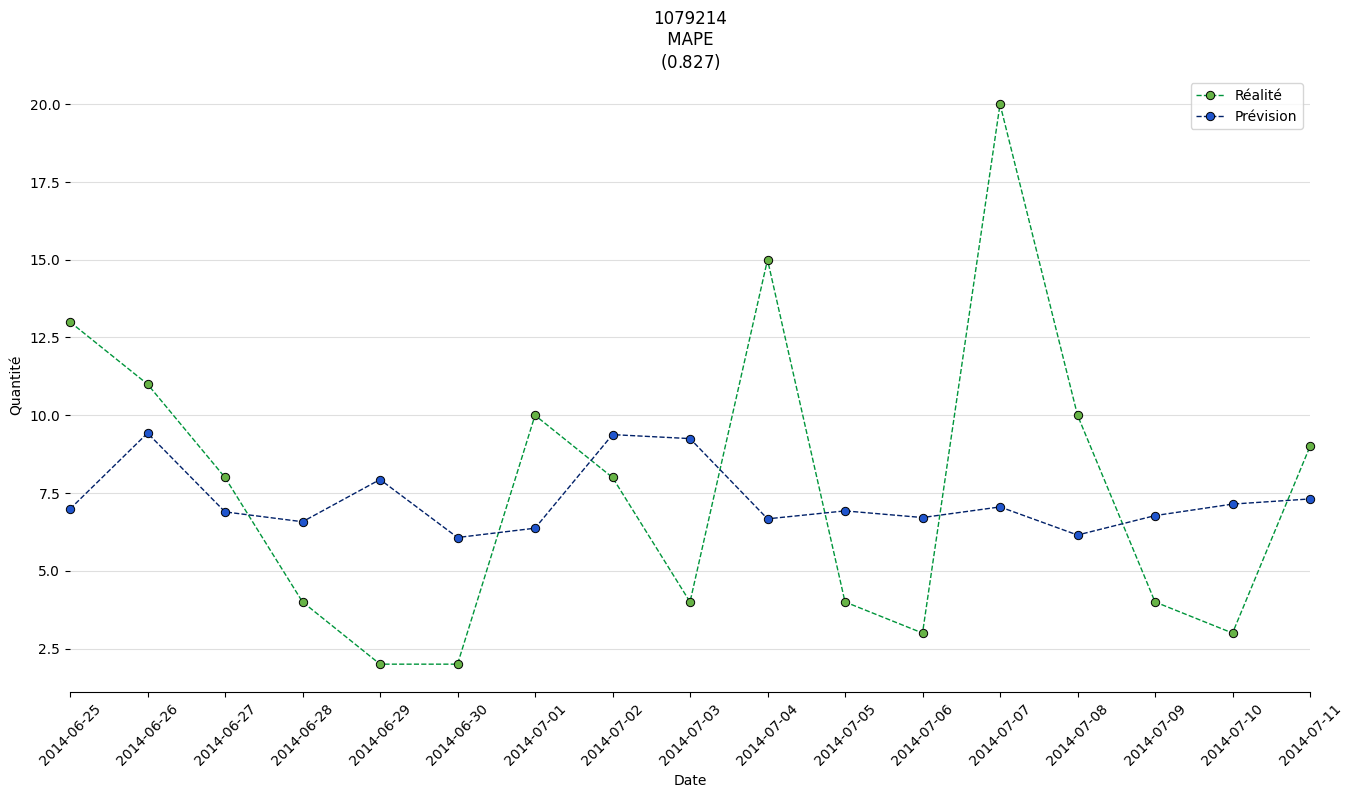

In [31]:
plt.rcParams['figure.figsize'] = (16, 8)
plot_forecast(
        dataframe=valid_ds.query('item_nbr == @random_ts[7]'),
        y_true="unit_sales",
        y_pred="yhat",
        time_col="date",
        title=random_ts[4],
        ylabel=r"Quantité",
        xlabel="Date"
        )

# Recursive Model

c'est un modèle entrainé à prédire t+1 dont les prédictions deviennent des variables.

In [32]:
from sklearn.ensemble import RandomForestRegressor

recursive_lags = np.arange(1, HORIZON+1)
shift_start_date = pd.to_datetime(timeserie_ds["date"].min()) + timedelta(days=int(max(recursive_lags)))
ds = timeserie_ds.copy()

for lag in recursive_lags:
  ds[f"y_t-{lag}"] = ds.groupby('item_nbr')['unit_sales'].transform(lambda x : x.shift(lag))

ds = ds.loc[ds['date'] >=  shift_start_date]
features = [f"y_t-{lag}" for lag in recursive_lags]

ds["is_train"] = np.where(ds['date'] < ds["date"].max() - pd.DateOffset(days=HORIZON), True, False)
rf = RandomForestRegressor(max_depth=10, random_state=12345, n_jobs=-1)
train_ds = ds.query('is_train == 1').dropna()
rf.fit(train_ds[features], train_ds['unit_sales'])
end_train = train_ds["date"].max()

In [36]:
valid_ds = (ds
            .query('is_train != 1')
            .sort_values(by=['item_nbr', 'date'])
            .assign(reality=lambda x : x["unit_sales"].copy())
)

for step in range(1, HORIZON+1):
    day = end_train + timedelta(days=step)
    print(f"Horizon = {step} and day = {day}")

    to_predict = (valid_ds.loc[valid_ds["date"] == day]
                  .copy(deep=True)
                  .sort_values(by=['item_nbr', 'date'])
                  .set_index(['item_nbr'])
                  )
    if step > 1:
      to_predict = (to_predict
             .drop(features, axis=1)
             .merge(next_lags, left_index=True, right_index=True, how="left")
      )

    to_predict["fcst"] = rf.predict(to_predict[features].fillna(0)).clip(0, None)
    valid_ds.loc[valid_ds['date'] == day , "unit_sales"] = to_predict["fcst"].values

    next_lags = to_predict[["fcst"] + features[:-1]]
    next_lags.columns = features


Horizon = 1 and day = 2014-06-25 00:00:00
Horizon = 2 and day = 2014-06-26 00:00:00
Horizon = 3 and day = 2014-06-27 00:00:00
Horizon = 4 and day = 2014-06-28 00:00:00
Horizon = 5 and day = 2014-06-29 00:00:00
Horizon = 6 and day = 2014-06-30 00:00:00
Horizon = 7 and day = 2014-07-01 00:00:00
Horizon = 8 and day = 2014-07-02 00:00:00
Horizon = 9 and day = 2014-07-03 00:00:00
Horizon = 10 and day = 2014-07-04 00:00:00
Horizon = 11 and day = 2014-07-05 00:00:00
Horizon = 12 and day = 2014-07-06 00:00:00
Horizon = 13 and day = 2014-07-07 00:00:00
Horizon = 14 and day = 2014-07-08 00:00:00
Horizon = 15 and day = 2014-07-09 00:00:00
Horizon = 16 and day = 2014-07-10 00:00:00


In [39]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(valid_ds['unit_sales'], valid_ds["reality"]))

7.627856059906528

<Axes: title={'center': '1079214\n MAPE \n($0.775$)'}, xlabel='Date', ylabel='Quantité'>

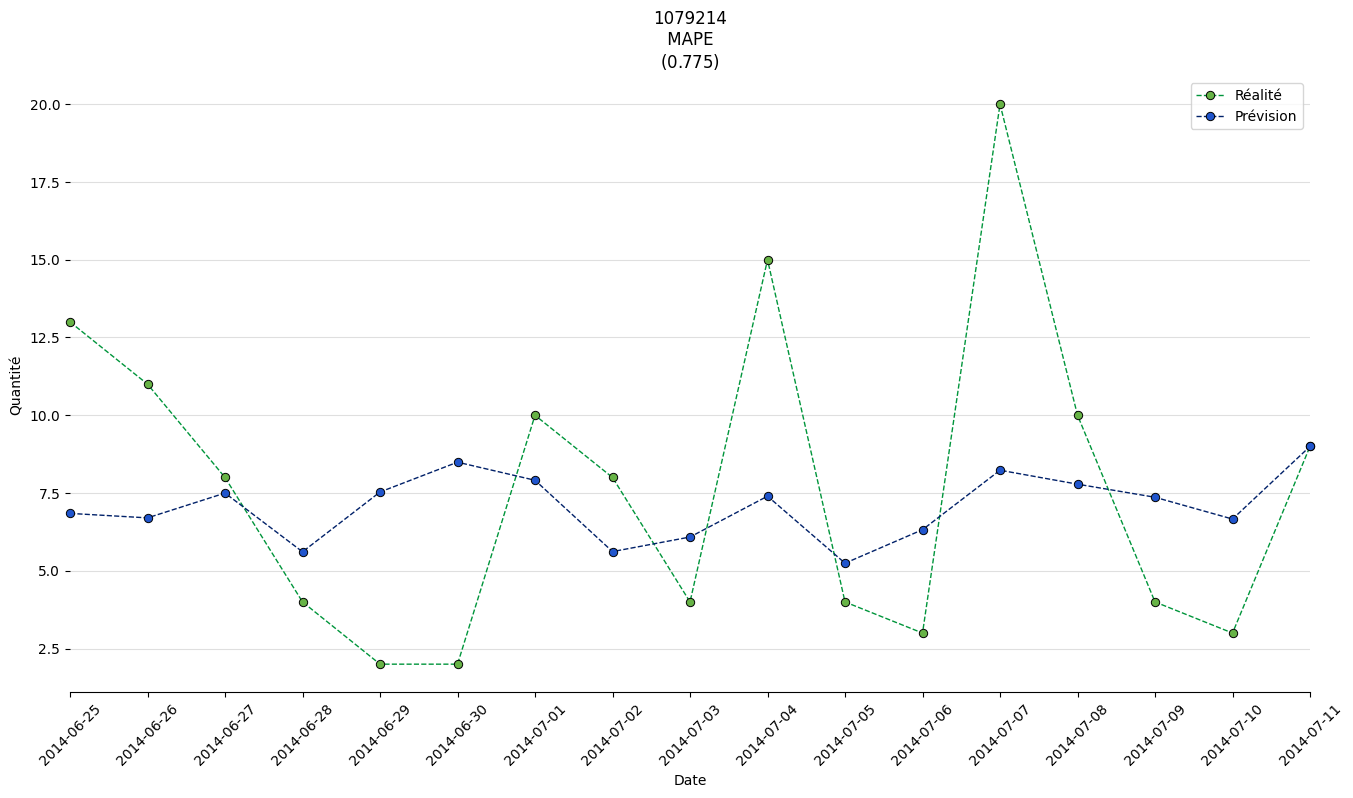

In [37]:
plt.rcParams['figure.figsize'] = (16, 8)

plot_forecast(
        dataframe=valid_ds.query('item_nbr == @random_ts[7]'),
        y_true="reality",
        y_pred="unit_sales",
        time_col="date",
        title=random_ts[4],
        ylabel=r"Quantité",
        xlabel="Date"
        )

# Model chainé

In [46]:
timeserie_ds["is_train"] = np.where(timeserie_ds['date'] < timeserie_ds["date"].max() - pd.DateOffset(days=HORIZON), True, False)

out = []
for step in range(1, HORIZON+1):
  ds = timeserie_ds.copy()

  lags_list_with_shift = np.arange(HORIZON)  + np.array(step)
  shift_start_date = pd.to_datetime(timeserie_ds["date"].min()) + timedelta(days=int(max(lags_list_with_shift)))
  print(f'model n°{step} - entrainé avec les lags suivants : {lags_list_with_shift}')

  for lag in lags_list_with_shift:
    ds[f"y_t-{lag}"] = ds.groupby('item_nbr')['unit_sales'].transform(lambda x : x.shift(lag))

  ds = ds.loc[ds['date'] >=  shift_start_date]
  features = [f"y_t-{lag}" for lag in lags_list_with_shift]

  train_ds = ds.loc[ds["is_train"] == True].dropna()
  valid_date = train_ds["date"].max() + timedelta(days=step)
  valid_ds = ds.query('is_train != True and date == @valid_date')

  rf = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=12345)
  rf.fit(train_ds[features], train_ds['unit_sales'])
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)
  out.append(valid_ds)

model n°1 - entrainé avec les lags suivants : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°2 - entrainé avec les lags suivants : [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°3 - entrainé avec les lags suivants : [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°4 - entrainé avec les lags suivants : [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°5 - entrainé avec les lags suivants : [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°6 - entrainé avec les lags suivants : [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°7 - entrainé avec les lags suivants : [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°8 - entrainé avec les lags suivants : [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°9 - entrainé avec les lags suivants : [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°10 - entrainé avec les lags suivants : [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°11 - entrainé avec les lags suivants : [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°12 - entrainé avec les lags suivants : [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°13 - entrainé avec les lags suivants : [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°14 - entrainé avec les lags suivants : [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°15 - entrainé avec les lags suivants : [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°16 - entrainé avec les lags suivants : [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]


<ipython-input-46-224d23f4bb28>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


<Axes: title={'center': '1079214\n MAPE \n($0.838$)'}, xlabel='Date', ylabel='Quantité'>

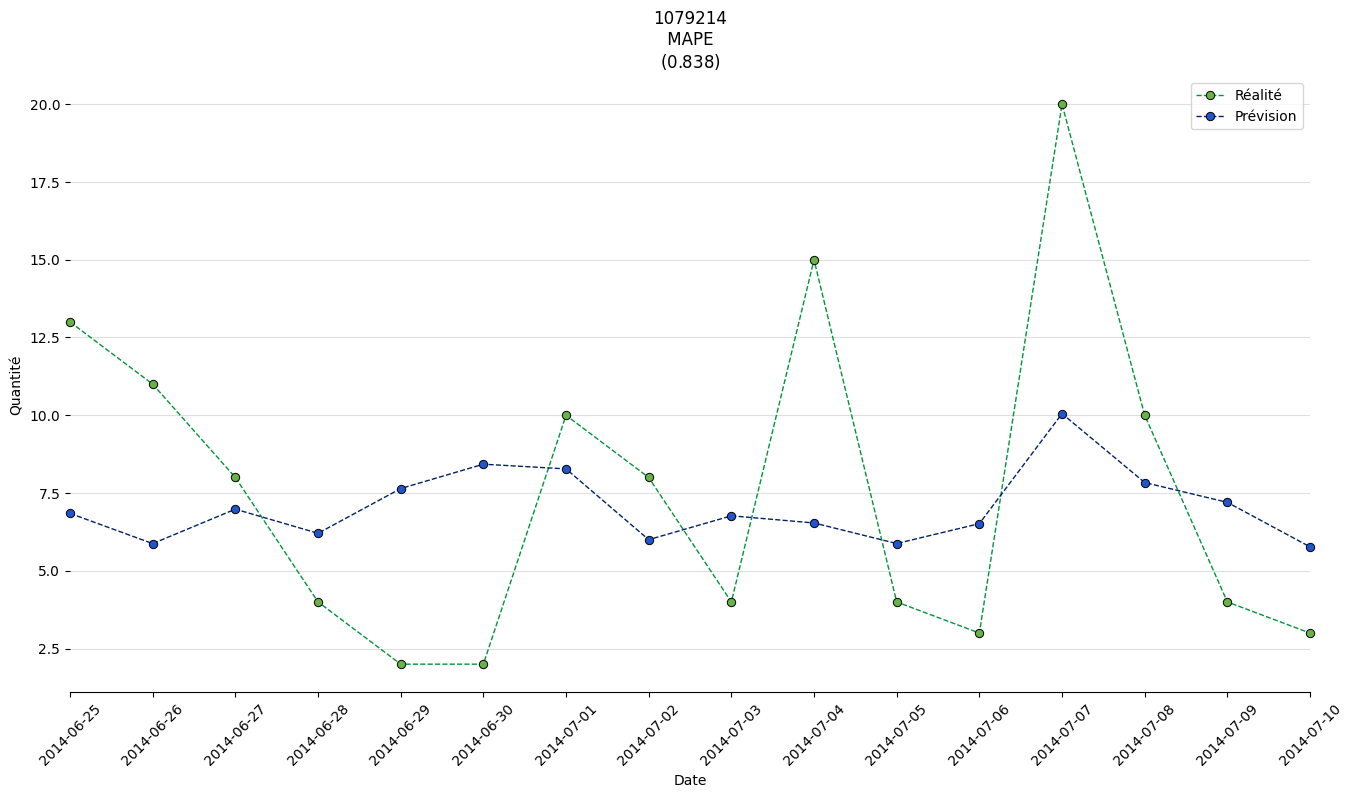

In [47]:
chain_valid = pd.concat(out)

print(np.sqrt(mean_squared_error(chain_valid['yhat'], chain_valid["unit_sales"])))

plt.rcParams['figure.figsize'] = (16, 8)

plot_forecast(
        dataframe=chain_valid.query('item_nbr == @random_ts[7]'),
        y_true="unit_sales",
        y_pred="yhat",
        time_col="date",
        title=random_ts[4],
        ylabel=r"Quantité",
        xlabel="Date"
        )

# Model partiellement chainé

In [70]:
out = []
splitted_horizon = np.split(np.arange(1, HORIZON+1), 2)
end_train = timeserie_ds["date"].max() - pd.DateOffset(days=HORIZON)

for bucket_horizon in splitted_horizon:
  ds = timeserie_ds.copy()

  lags_list_with_shift = np.arange(HORIZON)  + np.array(max(bucket_horizon))
  shift_start_date = pd.to_datetime(timeserie_ds["date"].min()) + timedelta(days=int(max(lags_list_with_shift)))
  print(f'model n°{bucket_horizon} - entrainé avec les lags suivants : {lags_list_with_shift}')

  for lag in lags_list_with_shift:
    ds[f"y_t-{lag}"] = ds.groupby('item_nbr')['unit_sales'].transform(lambda x : x.shift(lag))

  ds = ds.loc[ds['date'] >=  shift_start_date]
  features = [f"y_t-{lag}" for lag in lags_list_with_shift]

  train_ds = ds.query('is_train == 1').dropna()
  valid_st_date  = end_train + timedelta(days=int(min(bucket_horizon)))
  valid_end_date = end_train + timedelta(days=int(max(bucket_horizon)))
  valid_ds = ds.query('is_train !=1 and date.between(@valid_st_date, @valid_end_date, inclusive="both")')
  print(valid_ds.sort_values(by="date")["date"].unique())
  print(valid_st_date, valid_end_date)

  rf = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=12345)
  rf.fit(train_ds[features], train_ds['unit_sales'])
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)
  out.append(valid_ds)

pchain_valid = pd.concat(out)
print(np.sqrt(mean_squared_error(pchain_valid['yhat'], pchain_valid["unit_sales"])))


model n°[1 2 3 4 5 6 7 8] - entrainé avec les lags suivants : [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
['2014-06-26T00:00:00.000000000' '2014-06-27T00:00:00.000000000'
 '2014-06-28T00:00:00.000000000' '2014-06-29T00:00:00.000000000'
 '2014-06-30T00:00:00.000000000' '2014-07-01T00:00:00.000000000'
 '2014-07-02T00:00:00.000000000' '2014-07-03T00:00:00.000000000']
2014-06-26 00:00:00 2014-07-03 00:00:00


<ipython-input-70-fc91614d8b73>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


model n°[ 9 10 11 12 13 14 15 16] - entrainé avec les lags suivants : [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
['2014-07-04T00:00:00.000000000' '2014-07-05T00:00:00.000000000'
 '2014-07-06T00:00:00.000000000' '2014-07-07T00:00:00.000000000'
 '2014-07-08T00:00:00.000000000' '2014-07-09T00:00:00.000000000'
 '2014-07-10T00:00:00.000000000' '2014-07-11T00:00:00.000000000']
2014-07-04 00:00:00 2014-07-11 00:00:00
8.38185367723153


<ipython-input-70-fc91614d8b73>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


In [71]:
print(np.sqrt(mean_squared_error(pchain_valid['yhat'], pchain_valid["unit_sales"])))


8.38185367723153


In [73]:
pchain_valid.query('item_nbr == @random_ts[7]')

,date,store_nbr,item_nbr,unit_sales,onpromotion,y_t-1,y_t-2,y_t-3,y_t-4,y_t-5,...,y_t-23,yhat,y_t-24,y_t-25,y_t-26,y_t-27,y_t-28,y_t-29,y_t-30,y_t-31
25967060,2014-06-26,1.0,179615.0,11.0,False,13.0,9.0,11.0,1.0,4.0,...,3.0,10.024429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26016014,2014-06-27,1.0,179615.0,8.0,False,11.0,13.0,9.0,11.0,1.0,...,13.0,6.286293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26066410,2014-06-28,1.0,179615.0,4.0,False,8.0,11.0,13.0,9.0,11.0,...,11.0,6.815977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26121020,2014-06-29,1.0,179615.0,2.0,False,4.0,8.0,11.0,13.0,9.0,...,6.0,7.573822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26175152,2014-06-30,1.0,179615.0,2.0,False,2.0,4.0,8.0,11.0,13.0,...,8.0,7.443357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26227272,2014-07-01,1.0,179615.0,10.0,False,2.0,2.0,4.0,8.0,11.0,...,8.0,6.949379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26296567,2014-07-02,1.0,179615.0,8.0,False,10.0,2.0,2.0,4.0,8.0,...,2.0,6.001186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26365754,2014-07-03,1.0,179615.0,4.0,False,8.0,10.0,2.0,2.0,4.0,...,4.0,6.791702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26432727,2014-07-04,1.0,179615.0,15.0,False,4.0,8.0,10.0,2.0,2.0,...,14.0,7.160869,4.0,2.0,8.0,8.0,6.0,11.0,13.0,3.0
26499410,2014-07-05,1.0,179615.0,4.0,False,15.0,4.0,8.0,10.0,2.0,...,9.0,6.561482,14.0,4.0,2.0,8.0,8.0,6.0,11.0,13.0


<Axes: title={'center': '179615\n MAPE \n($0.809$)'}, xlabel='Date', ylabel='Quantité'>

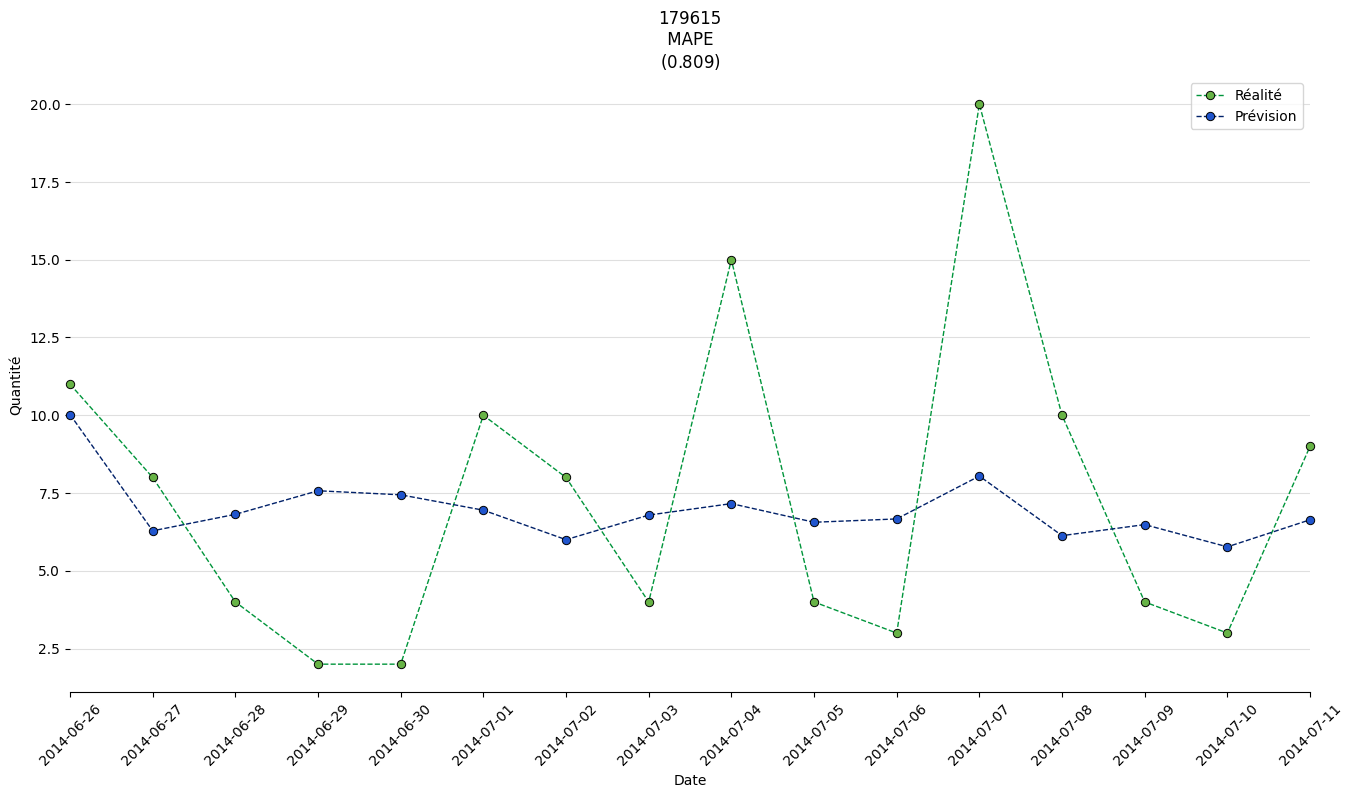

In [74]:
plt.rcParams['figure.figsize'] = (16, 8)

plot_forecast(
        dataframe=pchain_valid.query('item_nbr == @random_ts[7]'),
        y_true="unit_sales",
        y_pred="yhat",
        time_col="date",
        title=random_ts[7],
        ylabel=r"Quantité",
        xlabel="Date"
        )

# Model "Renversé"

In [96]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=11, random_state=12345, n_jobs=-1)
timeserie_ds["is_train"] = np.where(timeserie_ds['date'] < timeserie_ds["date"].max() - pd.DateOffset(days=HORIZON), 1, 0)

cal = pd.DataFrame()
cal['dt'] = pd.date_range('2013-01-01', '2017-12-31')
cal['week'] = cal["dt"].dt.isocalendar().week
cal['dayofweek'] = cal["dt"].dt.dayofweek + 1
cal['dow_name'] = cal["dt"].dt.day_name()

days_name = cal["dow_name"].unique().tolist()

cal['year'] = cal["dt"].dt.isocalendar().year
cal["max_wk_yr"] = cal.groupby('year')["week"].transform('max')
cal['year_int'] = cal["year"] - cal["year"].min()
cal = cal.assign(
    linear_week=lambda x :(x["year_int"] * x['max_wk_yr']) + x["week"],
    dt=lambda x : pd.to_datetime(x['dt'])
    )
max_weeks_from_year = cal.groupby('year')['week'].max()

tds = (timeserie_ds
       # .query('is_train == 1')
       .assign(dt=lambda x : pd.to_datetime(x['date']))
       .merge(cal, on=["dt"], how="inner")
)

lw = tds.query('dt>=@end_train')['linear_week'].unique()

week_dow_ts = (pd.pivot_table(data=tds,
                             values="unit_sales",
                             index=['item_nbr', 'linear_week'],
                             columns=['dow_name'],
                             aggfunc='mean')
               .set_axis(days_name, axis=1)
               .reset_index()
)

weeks_shift = [3, 4, 6, 8]

for shift in weeks_shift:
    lags_week_dow_ts = (week_dow_ts[['item_nbr', 'linear_week'] + days_name]
                        .copy()
                        .assign(linear_week=lambda x : np.int64(x['linear_week'] - shift))
                        .query('linear_week > 0')
                        )
    lags_week_dow_ts.columns = ['item_nbr', 'linear_week'] + [f"fe@{day}_shift_{shift}week" for day in days_name]
    week_dow_ts = week_dow_ts.merge(lags_week_dow_ts, how="left", on=['item_nbr', 'linear_week'])

week_dow_ts = week_dow_ts.loc[week_dow_ts["linear_week"] >= max(weeks_shift)]

week_dow_ts_train = week_dow_ts.loc[week_dow_ts["linear_week"] < min(lw)].dropna()
week_dow_ts_test = week_dow_ts.loc[week_dow_ts["linear_week"].isin(lw)]

features = list(filter(lambda x  : x.startswith('fe@'), week_dow_ts_train.columns))

for day in days_name:
  print(day)
  rf.fit(week_dow_ts_train[features], week_dow_ts_train[day])
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)

Tuesday


<ipython-input-96-c14f8510c78a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)


Wednesday


<ipython-input-96-c14f8510c78a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)


Thursday


<ipython-input-96-c14f8510c78a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)


Friday


<ipython-input-96-c14f8510c78a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)


Saturday


<ipython-input-96-c14f8510c78a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)


Sunday


<ipython-input-96-c14f8510c78a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)


Monday


<ipython-input-96-c14f8510c78a>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_dow_ts_test[f"{day}_fcst"] = rf.predict(week_dow_ts_test[features].fillna(0)).clip(0, None)


In [97]:
flatten_fcst_output = (week_dow_ts_test
 .set_index(['item_nbr', 'linear_week'])[[f"{x}_fcst" for x in days_name]]
 .stack()
 .to_frame('forecast')
 .reset_index()
 .rename(columns={"level_2": "dow_name"})
 .assign(dow_name=lambda x : x["dow_name"].str.split('_', expand=True).iloc[:, 0])
 .merge(cal[["dt", "linear_week", "dow_name"]], on=["linear_week", "dow_name"], how="left")
 .merge(tds[["item_nbr", "linear_week", "dt", "unit_sales"]], how="left", on=["item_nbr", "linear_week", "dt"])
)
flatten_fcst_output

,item_nbr,linear_week,dow_name,forecast,dt,unit_sales
0,114800.0,78,Tuesday,6.850000,2014-06-24,5.0
1,114800.0,78,Wednesday,4.080000,2014-06-25,2.0
2,114800.0,78,Thursday,6.850000,2014-06-26,15.0
3,114800.0,78,Friday,3.900000,2014-06-27,6.0
4,114800.0,78,Saturday,3.240000,2014-06-28,7.0
...,...,...,...,...,...,...
1668,1091366.0,80,Thursday,6.850000,2014-07-10,3.0
1669,1091366.0,80,Friday,3.900000,2014-07-11,6.0
1670,1091366.0,80,Saturday,3.240000,2014-07-12,NaN
1671,1091366.0,80,Sunday,17.791756,2014-07-13,NaN


<Axes: title={'center': '179615\n MAPE \n($1.265$)'}, xlabel='Date', ylabel='Quantité'>

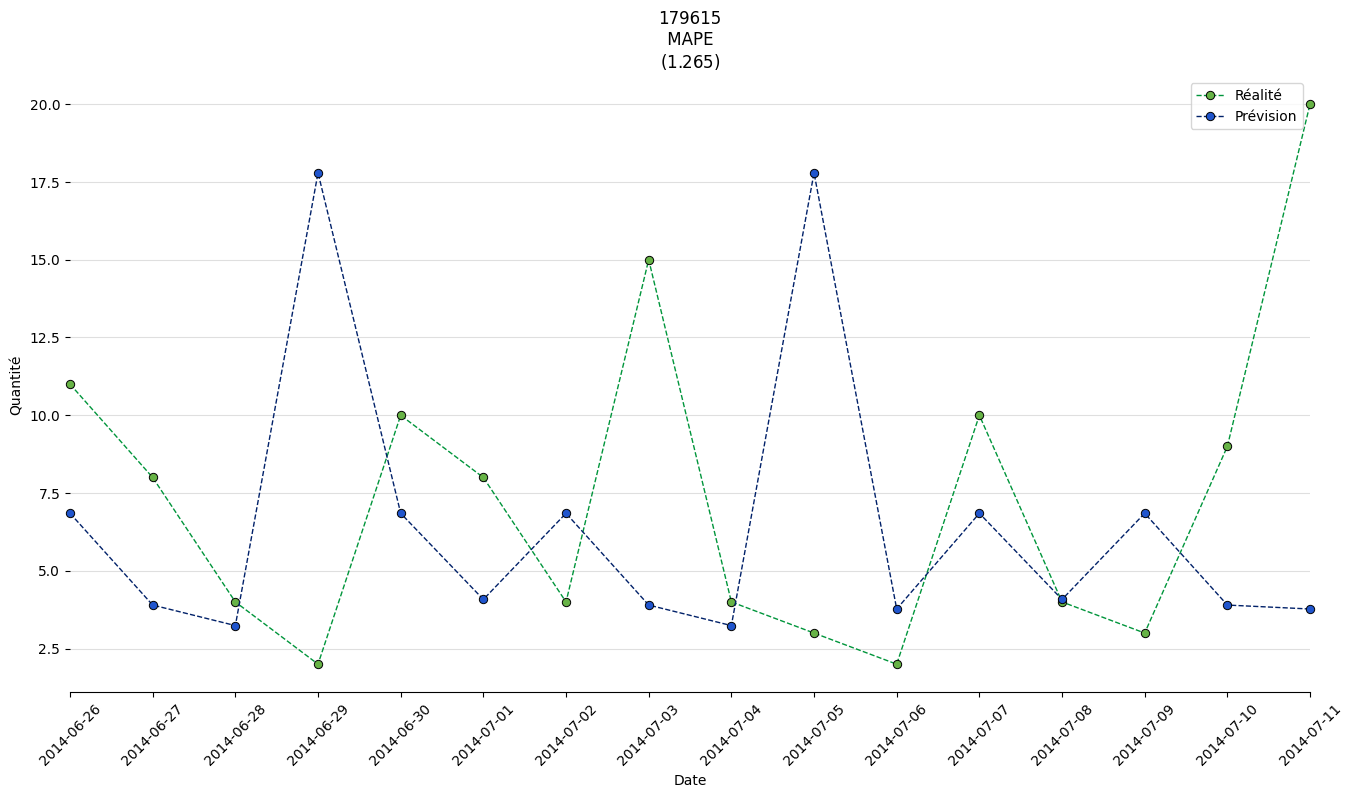

In [104]:
plt.rcParams['figure.figsize'] = (16, 8)

plot_forecast(
        dataframe=flatten_fcst_output.loc[(flatten_fcst_output['item_nbr'] == random_ts[7]) &
                                          (flatten_fcst_output["dt"].isin(pchain_valid["date"].unique()))
                                          ],
        y_true="unit_sales",
        y_pred="forecast",
        time_col="dt",
        title=random_ts[7],
        ylabel=r"Quantité",
        xlabel="Date"
        )

# Recency aggregation Method

In [109]:
end_train

Timestamp('2014-06-25 00:00:00')

In [124]:
rdf = timeserie_ds.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
rdf.columns = rdf.columns.get_level_values(1)
rdf = rdf.iloc[:, :-16]

In [131]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def fe(x, tdate, is_train):
  X = pd.DataFrame({ "day_1": get_timespan(x, tdate, 1, 1).values.ravel(),
        "mean_3": get_timespan(x, tdate, 3, 3).mean(axis=1).values,
        "mean_7": get_timespan(x, tdate, 7, 7).mean(axis=1).values,
        "mean_14": get_timespan(x, tdate, 14, 14).mean(axis=1).values,
        "mean_30": get_timespan(x, tdate, 30, 30).mean(axis=1).values,
        "mean_60": get_timespan(x, tdate, 60, 60).mean(axis=1).values,
        "mean_140": get_timespan(x, tdate, 140, 140).mean(axis=1).values
  })
  for i in range(7):
      X['mean_4_dow{}'.format(i)] = get_timespan(x, tdate, 28-i, 4, freq='7D').mean(axis=1).values
      X['mean_20_dow{}'.format(i)] = get_timespan(x, tdate, 140-i, 20, freq='7D').mean(axis=1).values

  if is_train:
        y = x[
            pd.date_range(tdate, periods=16)
        ].values
        return X, y
  return X

from datetime import date , timedelta
tdate = date(2014, 6, 25)

In [144]:
X_tr, y_tr = fe(rdf, tdate - timedelta(days=16*2), is_train=True)
X_test = fe(rdf, tdate - timedelta(days=16), is_train=False)

rf = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=12345)
rf.fit(X_tr, y_tr)
yhat = rf.predict(X_test).clip(0, None)

In [148]:
df_preds = pd.DataFrame(
    yhat, index=rdf.index,
    columns=pd.date_range(end_train, periods=16)
).stack().to_frame("yhat")

In [151]:
timeserie_ds.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,y_t-1,y_t-2,y_t-3,y_t-4,y_t-5,...,y_t-8,y_t-9,y_t-10,y_t-11,y_t-12,y_t-13,y_t-14,y_t-15,y_t-16,is_train
16324588,2014-01-02,1.0,114800.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
16391409,2014-01-03,1.0,114800.0,13.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
16456484,2014-01-04,1.0,114800.0,3.0,NaN,13.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
16525529,2014-01-05,1.0,114800.0,5.0,NaN,3.0,13.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
16593096,2014-01-06,1.0,114800.0,3.0,NaN,5.0,3.0,13.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [169]:
output = (df_preds
 .reset_index()
 .rename(columns={"level_2":"date"})
 .merge(timeserie_ds[["date", "store_nbr", "item_nbr", "unit_sales"]], how="left", on=["date", "store_nbr",
                                                                                                            "item_nbr"])
 .fillna(0)
 .pipe(lambda ds : ds.loc[ds["date"].isin(pchain_valid["date"].unique())])
)

In [170]:
print(np.sqrt(mean_squared_error(output['yhat'], output["unit_sales"])))


6.3468156674787295


<Axes: title={'center': '179615\n MAPE \n($1.097$)'}, xlabel='Date', ylabel='Quantité'>

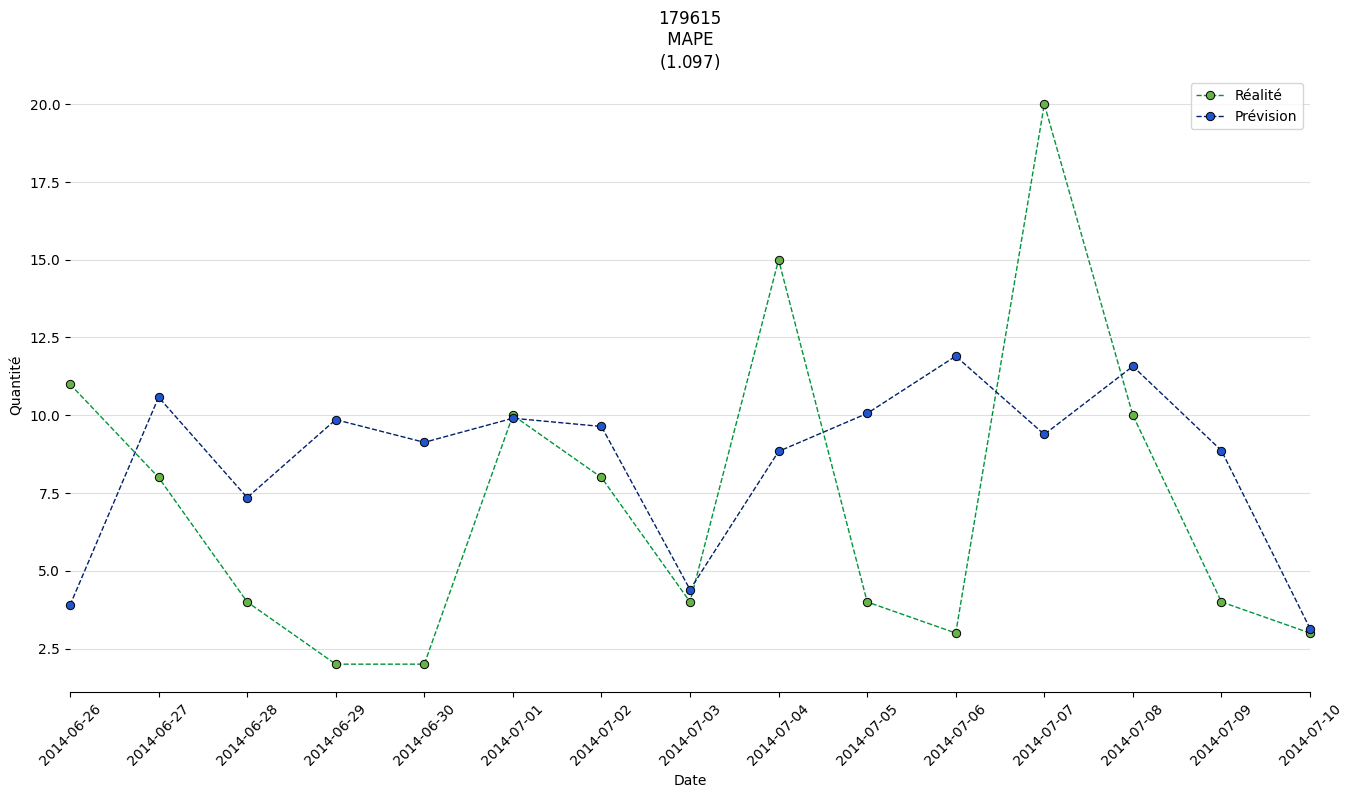

In [171]:
plt.rcParams['figure.figsize'] = (16, 8)

plot_forecast(
        dataframe=output.loc[(output['item_nbr'] == random_ts[7])],
        y_true="unit_sales",
        y_pred="yhat",
        time_col="date",
        title=random_ts[7],
        ylabel=r"Quantité",
        xlabel="Date"
        )

# Hierarchical

In [35]:
items = pd.read_csv('/content/data/items.csv')
df = df.merge(items, how="left", on=["item_nbr"])
end_train = df["date"].max()
HORIZON = 16
start_valid = end_train - pd.DateOffset(days=HORIZON)

In [19]:
items = pd.read_csv('/content/data/items.csv')
df = df.merge(items, how="left", on=["item_nbr"])
end_train = df["date"].max()
HORIZON = 16
start_valid = end_train - pd.DateOffset(days=HORIZON)
family_top_level = df.groupby(['date', 'store_nbr', 'family'], as_index=False)['unit_sales'].sum()
family_top_level.head()

,date,store_nbr,family,unit_sales
0,2014-01-02,1,BEVERAGES,36.0
1,2014-01-02,1,BREAD/BAKERY,44.0
2,2014-01-02,1,CLEANING,47.0
3,2014-01-02,1,DAIRY,13.0
4,2014-01-02,1,GROCERY I,102.0


In [52]:
lags_list_with_shift = np.arange(HORIZON)  + np.array(HORIZON)
shift_start_date = pd.to_datetime(family_top_level["date"].min()) + timedelta(days=int(max(lags_list_with_shift)))

for lag in lags_list_with_shift:
  family_top_level[f"y_t-{lag}"] = family_top_level.groupby('family')['unit_sales'].transform(lambda x : x.shift(lag))

family_top_level = family_top_level.loc[family_top_level['date'] >=  shift_start_date]
features = [f"y_t-{lag}" for lag in lags_list_with_shift]

train_ds = family_top_level.query('date < @start_valid')
valid_ds = family_top_level.query('date.between(@start_valid, @end_train, inclusive="left")')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=12345)
rf.fit(train_ds[features].fillna(0), train_ds['unit_sales'])
valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)
np.sqrt(mean_squared_error(valid_ds['yhat'], valid_ds["unit_sales"]))

<ipython-input-52-e22fc68b5923>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_ds['yhat'] = rf.predict(valid_ds[features].fillna(0)).clip(0, None)


11.028392199306378

In [83]:
historical_proportion = df.loc[df['date'].between(start_valid - pd.DateOffset(days=90), start_valid, inclusive="left")]
historical_proportion["dow"] = pd.to_datetime(historical_proportion["date"]).dt.dayofweek
dow_item_average = historical_proportion.groupby(["dow", 'item_nbr', 'family'], as_index=False)["unit_sales"].mean()
dow_item_average["family_sum"] = dow_item_average.groupby(['dow', 'family'])["unit_sales"].transform('sum')
dow_item_average['avg_item_proportion'] = dow_item_average['unit_sales'] / dow_item_average["family_sum"]
dow_item_average

<ipython-input-83-b499703306b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_proportion["dow"] = pd.to_datetime(historical_proportion["date"]).dt.dayofweek


,dow,item_nbr,family,unit_sales,family_sum,avg_item_proportion
0,0,105857,GROCERY I,5.416667,109.781799,0.049340
1,0,108797,GROCERY I,2.100000,109.781799,0.019129
2,0,115847,LINGERIE,2.250000,2.250000,1.000000
3,0,121964,AUTOMOTIVE,1.000000,1.000000,1.000000
4,0,155625,GROCERY I,1.500000,109.781799,0.013663
...,...,...,...,...,...,...
530,6,1047774,BEVERAGES,5.375000,25.408333,0.211545
531,6,1047790,BEVERAGES,5.600000,25.408333,0.220400
532,6,1052022,DAIRY,3.000000,10.658333,0.281470
533,6,1085246,MEATS,1.460333,4.864333,0.300212


In [99]:
fcst = (valid_ds[["date", "store_nbr", "family", "unit_sales", "yhat"]]
 .assign(dow=lambda x : pd.to_datetime(x['date']).dt.dayofweek)
 .merge(dow_item_average[["dow", "item_nbr", "family", "avg_item_proportion"]], how="inner", on=["dow", "family"])
 .assign(yhat_reconst=lambda x : x['unit_sales']*x["avg_item_proportion"])
 .merge(df.query('date.between(@start_valid, @end_train, inclusive="left")')[["date", "item_nbr", "unit_sales"]].rename(columns={"unit_sales":"item_unit_sales"}),
        )
)
fcst

,date,store_nbr,family,unit_sales,yhat,dow,item_nbr,avg_item_proportion,yhat_reconst,item_unit_sales
0,2017-07-30,1,BEVERAGES,19.000,17.330092,6,886067,0.308298,5.857658,6.000
1,2017-07-30,1,BEVERAGES,19.000,17.330092,6,1047774,0.211545,4.019351,10.000
2,2017-07-30,1,BEVERAGES,19.000,17.330092,6,1047790,0.220400,4.187602,2.000
3,2017-07-30,1,BEVERAGES,19.000,17.330092,6,1102971,0.062971,1.196458,1.000
4,2017-08-06,1,BEVERAGES,14.000,14.416440,6,886067,0.308298,4.316169,5.000
...,...,...,...,...,...,...,...,...,...,...
711,2017-08-10,1,DELI,3.000,2.648018,3,407533,0.494505,1.483516,1.000
712,2017-08-10,1,DELI,3.000,2.648018,3,418024,0.285714,0.857143,1.000
713,2017-08-10,1,DELI,3.000,2.648018,3,619965,0.219780,0.659341,1.000
714,2017-08-10,1,MEATS,18.747,6.088463,3,584246,0.692524,12.982754,18.747


<Axes: title={'center': '902202\n MAPE \n($0.456$)'}, xlabel='Date', ylabel='Quantité'>

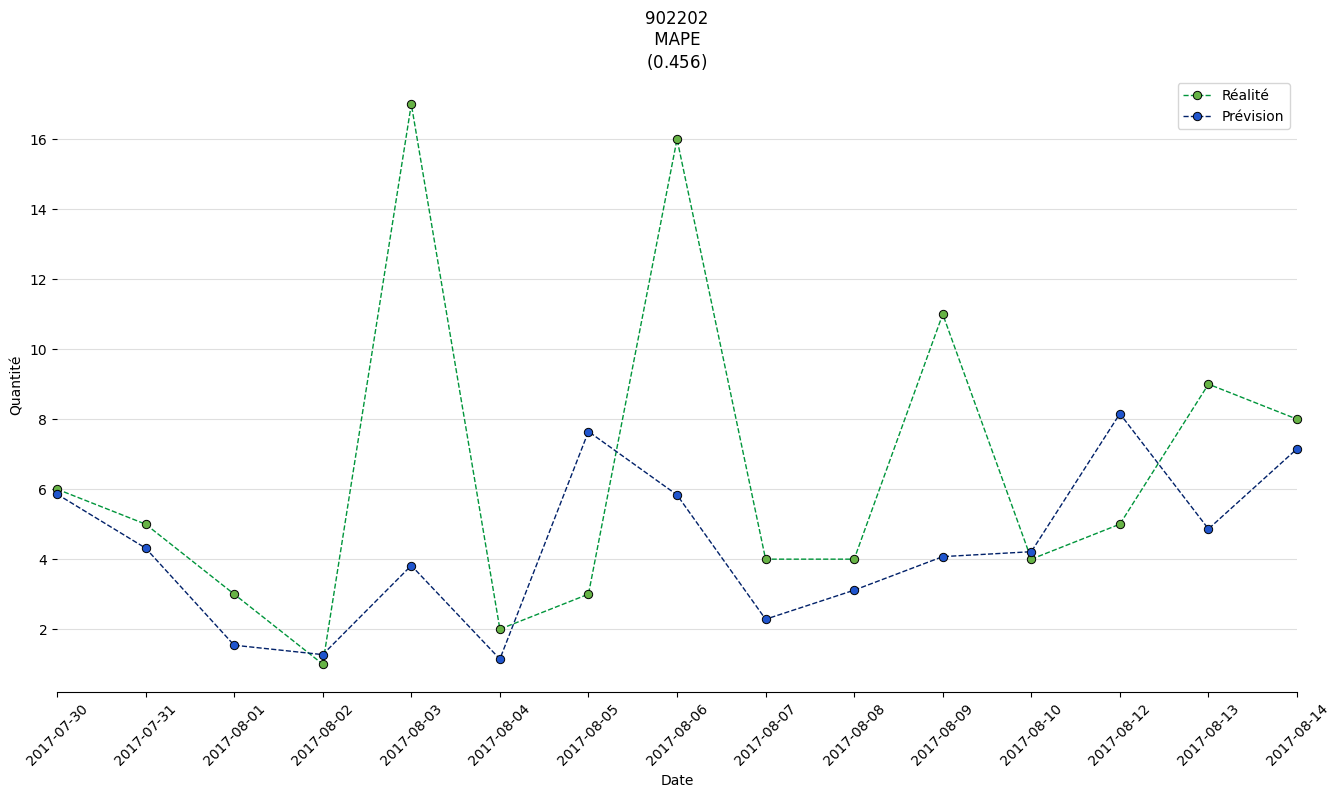

In [103]:
plt.rcParams['figure.figsize'] = (16, 8)

plot_forecast(
        dataframe=fcst.loc[(fcst['item_nbr'] == 886067)],
        y_true="item_unit_sales",
        y_pred="yhat_reconst",
        time_col="date",
        title=random_ts[7],
        ylabel=r"Quantité",
        xlabel="Date"
        )